## Covid19 Analysis & Forecast
#### by Khairul Omar
https://github.com/khairulomar/Covid-19<br>
https://www.linkedin.com/in/khairulomar/

### 1. Import and clean data

In [1]:
# Import libraries
import pandas as pd
pd.options.display.max_rows = 200
import numpy as np
import math
import json
import requests
import os
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.optimize import curve_fit
import warnings
from IPython.display import Image
warnings.filterwarnings("ignore")

In [2]:
# # Multiple downloads from John Hopkins Hospital database
# start  = pd.to_datetime(f'20200122', format='%Y%m%d')
# oneday = pd.Timedelta(1, unit='days')
# end    = pd.to_datetime(f'20200315', format='%Y%m%d')
# for d in range((end - start).days+1):
#     date = start + oneday * d
#     day, month, year = str(date)[8:10], str(date)[5:7], str(date)[:4]
#     url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{month}-{day}-{year}.csv'
#     df = pd.read_csv(url)
#     df.to_csv(f'csv/{month}-{day}-{year}.csv')

In [3]:
# One-day download from John Hopkins Hospital database
day = 29
month = 3
date  = pd.to_datetime(f"20200{month}{0 if day<10 else ''}{day}", format='%Y%m%d')
day0, month0, year0 = str(date)[8:10], str(date)[5:7], str(date)[:4]
url = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{month0}-{day0}-{year0}.csv'
zero = 0 if day < 10 else ''
df = pd.read_csv(url)
df.to_csv(f'csv2/0{month}-{zero}{day}-2020.csv')

In [4]:
# Process files with formatting prior to 23/03/2020
path = 'csv/'
fileList = os.listdir(path)
df = pd.DataFrame()
for file in fileList:
    if file.endswith('.csv'):
        df0 = pd.read_csv(f'{path}{file}')
        df0.columns = map(str.lower, df0.columns)
        df0 = df0.rename(columns={'country/region':'country'})
        df0 = df0.rename(columns={'province/state':'state'})
        df0 = df0.rename(columns={'last update':'updated'})
        df0 = df0[['updated','country','state','confirmed','deaths','recovered']]
        df0.updated = pd.to_datetime(df0.updated)
        df0.state = df0.state.fillna('')
        df0['date'] = pd.to_datetime(f'{file[6:10]}{file[0:2]}{file[3:5]}', format='%Y%m%d')
        df0['fips'] = 0
        for col in ['confirmed','deaths','recovered']:
            df0[col] = df0[col].fillna(0)
            df0[col] = df0[col].astype(int)
        df = pd.concat([df, df0])
    df01 = df.copy()
        
# Process files with formatting from 23/03/2020
path = 'csv2/'
fileList = os.listdir(path)
df = pd.DataFrame()
for file in fileList:
    if file.endswith('.csv'):
        df0 = pd.read_csv(f'{path}{file}')
        df0.columns = map(str.lower, df0.columns)
        df0 = df0.rename(columns={'country_region':'country'})
        df0 = df0.rename(columns={'province_state':'state'})
        df0 = df0.rename(columns={'last_update':'updated'})
        df0 = df0[['updated','country','state','confirmed','deaths','recovered','fips','admin2']]
        df0.updated = pd.to_datetime(df0.updated)
        df0.state = df0.state.fillna('')
        df0['date'] = pd.to_datetime(f'{file[6:10]}{file[0:2]}{file[3:5]}', format='%Y%m%d')
        for col in ['confirmed','deaths','recovered', 'fips']:
            df0[col] = df0[col].fillna(0)
            df0[col] = df0[col].astype(int)
        df = pd.concat([df, df0])
    df02 = df.copy()
    
# Append data from Hubei prior to 22/01/2020
raw = pd.read_csv('csv/older/pre_01-22-2020.csv')
prior = pd.DataFrame(columns=df0.columns)
for col in ['confirmed', 'country', 'deaths', 'recovered', 'state', 'updated']:
    prior[col] = raw[col]
for col in ['confirmed', 'deaths', 'recovered']:
    prior[col] = prior[col].astype(int)
prior.state = 'Hubei'
prior.country = 'Mainland China'
prior.fips = 0
prior.updated = pd.to_datetime(prior.updated, format='%d/%m/%Y')
prior.date = prior.updated

df = pd.concat([df02, df01, prior]).reset_index()
df0 = df.copy()

In [5]:
df = df0.copy()

# Geo clean-up mapping dictionary
geo = json.load(open('geo.json'))
df.country = df.country.apply(lambda row: geo['countries'][row] if row in list(geo['countries'].keys()) else row)
df['temp'] = ''
for i in range(len(df)):
    state = df.iloc[i].state
    country = df.iloc[i].country
    if state in ['Channel Islands', 'Gibraltar', 'Cayman Islands',
                 'Faroe Islands']:
        df.iloc[i, df.columns.get_loc('country')] = df.iloc[i, df.columns.get_loc('state')]
    elif (state == country) | (state == 'None') | (state == 'UK'):
        df.iloc[i, df.columns.get_loc('state')] = country
    elif state.find('Princess') > 0:
        if country != 'Cruise Ship':
            df.iloc[i, df.columns.get_loc('state')] = f'Cruise {country}'
        else:
            df.iloc[i, df.columns.get_loc('state')] = 'Cruise Ship'
    elif country == 'United States':
        if state == 'Washington, D.C.':
            s = 'District of Columbia'
        elif state == 'US':
            s = 'Unassigned'
        elif state == 'Chicago':
            s = 'Illinois'
        elif (state == "Virgin Islands, U.S.") | (state == "United States Virgin Islands"):
            s = 'Virgin Islands'
        elif state.find(', ') > 0:
            s0 = state[state.find(', ')+2:state.find(', ')+4]
            s = geo['us_states'][s0]
        elif state in list(geo['us_states'].keys()):
            s = geo['us_states'][state]
        else:
            s = state
        df.iloc[i, df.columns.get_loc('temp')] = s
    elif country == 'Canada':
        if state.find('Princess') > 0:
            s = 'Cruise Ship'               
        elif state.find(', ') > 0:
            ca = {'Edmonton, Alberta':'Alberta', 'Calgary, Alberta':'Alberta',
                  'London, ON':'Ontario', 'Toronto, ON':'Ontario', ' Montreal, QC':'Quebec'}
            s = ca[state]
        else:
            s = state
        df.iloc[i, df.columns.get_loc('temp')] = s

df['state'] = df.apply(lambda row: row['temp'] if row['temp']!='' else (row['state'] if row['state']!='' else row['country']), axis=1)
df.drop('temp', axis=1, inplace=True)

df = pd.pivot_table(df, values=['confirmed','deaths','recovered'], index=['date','updated','country','state'], columns=None, aggfunc='sum')
df = df.rename(columns={'confirmed':'confirmed_raw'})
df = df.reset_index()
dftemp = pd.DataFrame()
for state in df.state.unique():
    dfstate = df[df.state==state].copy()
    dfstate = dfstate.sort_index(ascending=False)
    dfstate['confirmed'] = dfstate.confirmed_raw
    # Replace raw with average between 2 dates due to incomplete data due to cut-off reporting time
    # e.g. if new cases suddenly drop by 90% in one day, most likely it's due to incomplete data
    for i in range(1,len(dfstate.index)-1):
        ratio = 1/2 # smoothing average ratio
        if dfstate.iloc[i+1].confirmed_raw / dfstate.iloc[i].confirmed_raw > 0.9:
            dfstate.iloc[i, dfstate.columns.get_loc('confirmed')] = int(dfstate.iloc[i+1].confirmed_raw * ratio
                                                                        + dfstate.iloc[i-1].confirmed_raw * (1-ratio))
    for col in ['confirmed','deaths','recovered']:
        colname = f'new_{col}'
        dfstate[colname] = dfstate[col].diff(-1)
        dfstate[colname] = dfstate[colname].fillna(dfstate[col])
        dfstate[colname] = dfstate[colname].astype('int')
    dftemp =  pd.concat([dftemp, dfstate])
df = dftemp.sort_values(['date','new_confirmed'], ascending=False)
allcols = ['date','updated', 'country', 'state', 'confirmed', 'deaths', 'recovered', 'new_confirmed', 'new_deaths', 'new_recovered']
df = df[allcols]
df = df.reset_index(drop=True)

In [6]:
# Country-level data
df1 = pd.pivot_table(df, values=df.columns[4:], index=['date','country'], columns=None, aggfunc='sum')
df1 = df1.reset_index()
df1 = df1.sort_values(['date','confirmed'], ascending=False)
df1 = df1[['date','country'] + allcols[-6:]]
df1 = df1.set_index('date')

### 2. Analyse latest data

In [7]:
# Display one day data
day = day
month = month
date = pd.to_datetime(f"20200{month}{0 if day<10 else ''}{day}", format='%Y%m%d')
oneday = pd.Timedelta(1, unit='days')

top0 = 50
latest = df1.loc[date]
print(f'\nTop {top0} countries by total cases as of {date.day}/{date.month}/2020')
display(latest[:top0])


Top 50 countries by total cases as of 29/3/2020


,country,confirmed,deaths,recovered,new_confirmed,new_deaths,new_recovered
date,,,,,,,
2020-03-29,United States,140886,2467,2665,19115,510,2181
2020-03-29,Italy,97689,10779,13030,5596,756,646
2020-03-29,China,82122,3304,75582,116,5,482
2020-03-29,Spain,80110,6803,14709,6875,821,2424
2020-03-29,Germany,62095,533,9211,4400,100,730
2020-03-29,France,40708,2611,7226,2603,294,1502
2020-03-29,Iran,38309,2640,12391,2989,123,712
2020-03-29,United Kingdom,19599,1228,137,2443,209,0
2020-03-29,Switzerland,14829,300,1595,951,36,65



New confirmed cases from 1/2/2020 to 29/3/2020


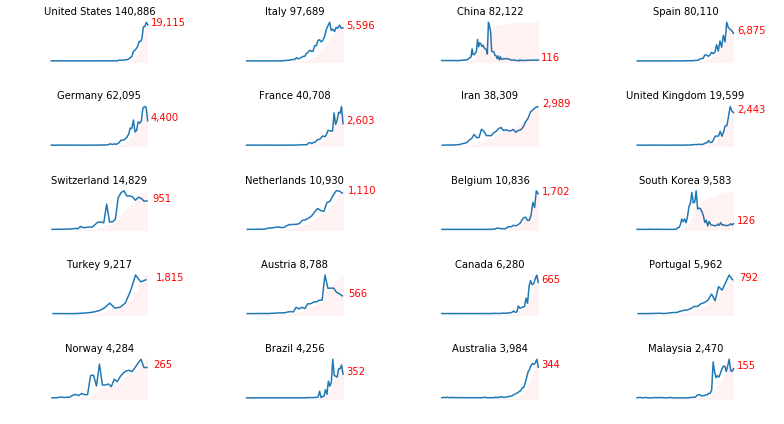

In [8]:
top = 20
# Select diplay data
until = date
data = df1[until:]

# Plot data
print(f'\nNew confirmed cases from 1/2/2020 to {date.day}/{date.month}/2020')
countries = list(latest[:top-2].country) + ['Australia', 'Malaysia']
# countries.remove('Cruise Ship')
fig, axes = plt.subplots(ncols=4, nrows=round(len(countries)/4), figsize=(11,6), constrained_layout=True)
for i, ax in zip(range(len(countries)), axes.flat):
    cdata = data[data.country==countries[i]]
    ax.plot(cdata.new_confirmed)
    ax.text(until + oneday*2, cdata.loc[until].new_confirmed, format(cdata.loc[until].new_confirmed, ","), color='red')
    ax2 = ax.twinx()
    ax2.bar(cdata.index, cdata.confirmed, color='red', alpha=0.05, width=1)
    ax.set_title(f'{countries[i]} {format(cdata.loc[until].confirmed, ",")}', fontsize=10)
    ax.axis('off')
    ax2.axis('off')
plt.tight_layout()
plt.show()

In [9]:
print(f'\nNew confirmed cases by Top 10 US State as of {date.day}/{date.month}/2020')
usa = df[df.country=='United States'].set_index('date').iloc[:10,2:]
usa


New confirmed cases by Top 10 US State as of 29/3/2020


,state,confirmed,deaths,recovered,new_confirmed,new_deaths,new_recovered
date,,,,,,,
2020-03-29,New York,59648,965,0,7238,237,0
2020-03-29,New Jersey,13386,161,0,2262,21,0
2020-03-29,Illinois,4596,66,0,1105,19,0
2020-03-29,Michigan,5488,132,0,838,21,0
2020-03-29,Massachusetts,4955,48,0,698,4,0
2020-03-29,California,5852,124,0,598,14,0
2020-03-29,Pennsylvania,3432,41,0,587,7,0
2020-03-29,Colorado,2307,47,0,567,16,0
2020-03-29,Florida,4246,56,0,483,2,0


In [10]:
print(f'\nNew confirmed cases by Top 10 US County as of {date.day}/{date.month}/2020')
county = df0.loc[(df0.country=='US') & (df0.date==date)].sort_values(by='confirmed', ascending=False).set_index('date', drop=True)
county = county[['admin2', 'state', 'confirmed', 'deaths', 'recovered']]
county[:10]


New confirmed cases by Top 10 US County as of 29/3/2020


,admin2,state,confirmed,deaths,recovered
date,,,,,
2020-03-29,New York City,New York,33768,678,0
2020-03-29,Westchester,New York,8519,10,0
2020-03-29,Nassau,New York,6445,39,0
2020-03-29,Suffolk,New York,5023,40,0
2020-03-29,Cook,Illinois,3445,40,0
2020-03-29,Unassigned,New Jersey,3020,56,0
2020-03-29,Wayne,Michigan,2704,56,0
2020-03-29,Rockland,New York,2209,8,0
2020-03-29,Bergen,New Jersey,2169,23,0


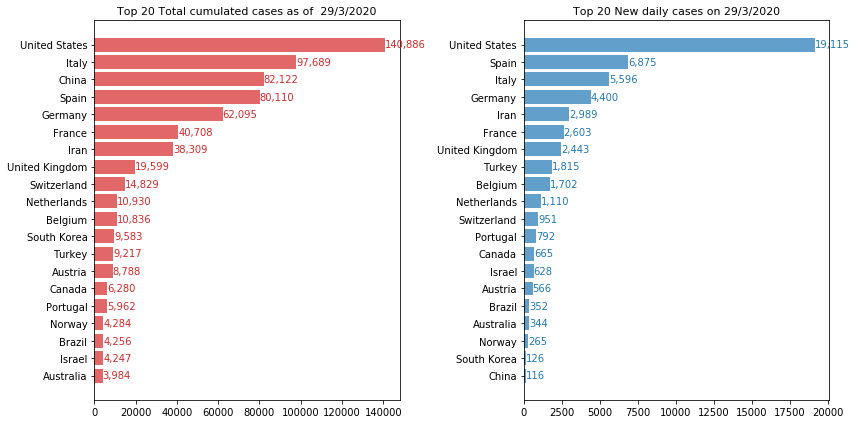

In [11]:
cols = ['confirmed','new_confirmed']
titles = ['Total cumulated cases as of  ','New daily cases on ']
colors = ['C3','C0']
fig, axes = plt.subplots(figsize=(12,6), nrows=1, ncols=2)
for i, ax in zip(range(len(cols)), axes.flat):
    data = latest[:top][['country',cols[i]]].reset_index(drop=True).set_index('country').sort_values(by=cols[i])
    ax.barh(data.index, data[cols[i]], color=colors[i], alpha=0.7)
    ax.set_title(f'Top {top} {titles[i]}{date.day}/{date.month}/2020', fontsize='11')
    for n, v in enumerate(data[cols[i]]):
        ax.text(v, n, format(v, ","), va='center', fontsize=10, color=colors[i])
plt.tight_layout()
plt.savefig('img/total_cases_bar', pad_inches=0)
plt.show()

In [12]:
threshold = 50 # set min threshold
rolling_window = 2
df2 = df1[['country', 'confirmed', 'new_confirmed']].sort_index().reset_index()
dftemp = pd.DataFrame()
for country in df2.country.unique():
    dfc = df2[df2.country==country].copy().reset_index(drop=True)
    dfc['growth'] = 0
    dfc['new_growth'] = 0
    for i in range(1,len(dfc.index)):
        for newcol in ['growth', 'new_growth']:
            oldcol = 'confirmed' if newcol == 'growth' else 'new_confirmed'
            dfc.iloc[i, dfc.columns.get_loc(newcol)] = 0 if dfc.iloc[i-1][oldcol] == 0 else round(dfc.iloc[i][oldcol]/dfc.iloc[i-1][oldcol],2)
    dftemp =  pd.concat([dftemp, dfc])
df2 = dftemp[dftemp.confirmed > threshold] # ignore cases below threshold
df2['growth_avg'] = round(df2.growth.rolling(window=rolling_window).mean(),2)
df2 = df2.reset_index(drop=True)

In [13]:
print(f'\nTop 20 countries with the highest day-on-day growth as of {date.day}/{date.month}/2020')
growthdata = df2.loc[(df2.date==date) & (df2.confirmed > 100)].sort_values(by='growth', ascending=False).set_index('country', drop=True)
growthdata[['confirmed','growth','growth_avg']][:20]


Top 20 countries with the highest day-on-day growth as of 29/3/2020


,confirmed,growth,growth_avg
country,,,
Georgia,2508,2.05,1.61
Uzbekistan,144,1.38,1.28
Ukraine,475,1.33,1.24
Philippines,1418,1.32,1.33
Nigeria,111,1.25,1.20
Romania,1815,1.25,1.19
Kazakhstan,284,1.25,1.38
Turkey,9217,1.25,1.27
Cote d'Ivoire,165,1.24,1.30



Day-to-day % growth of new confirmed cases for 4 weeks prior to 29/3/2020


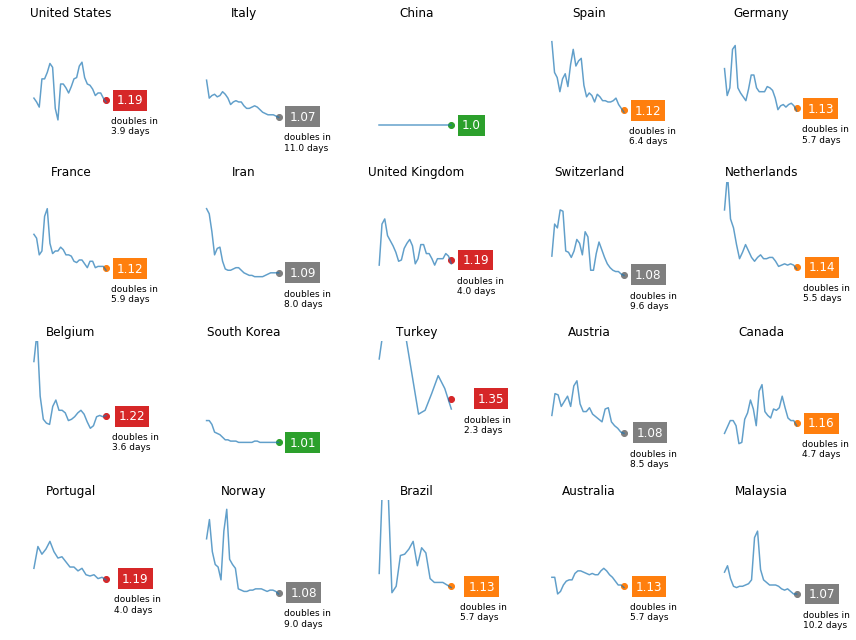

In [33]:
countries = list(latest[:18].country) + ['Australia', 'Malaysia']

print(f'\nDay-to-day % growth of new confirmed cases for 4 weeks prior to {date.day}/{date.month}/2020')
fig, axes = plt.subplots(ncols=5, nrows=round(len(countries)/5), figsize=(12,9), constrained_layout=True)
col = ['growth_avg']
for i, ax in zip(range(len(countries)), axes.flat):
    data = df2[df2.country==countries[i]].iloc[-28:].reset_index(drop=True)
    ax.plot(data[col].clip(1)[:], alpha=0.7)
    latest_growth = data[col].rolling(window=2).mean().iloc[-1]
    if latest_growth[0] < 2**(1/14):
        color = 'C2'
    elif latest_growth[0] < 2**(1/7):
        color = 'C7'
    elif latest_growth[0] < 2**(1/4):
        color = 'C1'
    else: color = 'C3'
    double_days = f'doubles in\n{round(math.log(2)/math.log(latest_growth),1)} days' if latest_growth[0] > 2**(1/30) else ''
    ax.scatter(data.index.max(), latest_growth, marker='o', color=color)
    #ax.hlines(0,data.index.min(),data.index.max(), alpha=0.1)
    ax.text(data.index.max()+4, latest_growth, str(round(latest_growth[0],2)),
            color='white', ha='left', va='center', size=12, bbox=dict(facecolor=color, edgecolor='none'))
    ax.text(data.index.max()+2, latest_growth-0.2, double_days, ha='left', va='center', size=9)
    ax.set_ylim(0.9, 1.8)
    ax.axis('off')
    ax.set_title(countries[i], fontsize=12)
plt.tight_layout()
plt.savefig('img/growth', pad_inches=0)
plt.savefig(f'img_archive/growth_{str(date)[:10]}', pad_inches=0)
plt.show()

In [15]:
print('Day-to-day % growth of new confirmed cases over the past 7 days')
dfgrowth = pd.pivot_table(df2, values=['growth'], index=['country'], columns=['date'], aggfunc='sum').loc[countries]
dfgrowth.iloc[:,-7:]

Day-to-day % growth of new confirmed cases over the past 7 days


growth                                              \
date           2020-03-23 2020-03-24 2020-03-25 2020-03-26 2020-03-27   
country                                                                 
United States        1.31       1.24       1.22       1.28       1.22   
Italy                1.09       1.08       1.08       1.07       1.08   
China                1.00       1.00       1.00       1.00       1.00   
Spain                1.22       1.14       1.24       1.17       1.14   
Germany              1.17       1.14       1.13       1.18       1.16   
France               1.24       1.12       1.13       1.15       1.13   
Iran                 1.06       1.08       1.08       1.09       1.09   
United Kingdom       1.17       1.22       1.18       1.22       1.25   
Switzerland          1.14       1.12       1.10       1.10       1.09   
Netherlands          1.13       1.17       1.15       1.16       1.16   
Belgium              1.13       1.11       1.16       1.26       1.17   
South Korea          1.01       1.01       1.01       1.01       1.01   
Turkey               1.24       1.22       1.30       1.49       1.57   
Austria              1.38       1.18       1.15       1.13       1.10   
Canada               1.39       1.34       1.22       1.19       1.18   
Portugal             1.29       1.15       1.27       1.18       1.20   
Norway               1.10       1.09       1.09       1.10       1.10   
Brazil               1.21       1.17       1.14       1.17       1.14   
Australia            1.23       1.22       1.19       1.15       1.14   
Malaysia             1.12       1.09       1.10       1.11       1.07   

                                      
date           2020-03-28 2020-03-29  
country                               
United States        1.19       1.16  
Italy                1.06       1.06  
China                1.00       1.00  
Spain                1.11       1.09  
Germany              1.13       1.08  
France               1.14       1.07  
Iran                 1.09       1.08  
United Kingdom       1.18       1.14  
Switzerland          1.07       1.07  
Netherlands          1.14       1.11  
Belgium              1.25       1.19  
South Korea          1.01       1.01  
Turkey               1.30       1.25  
Austria              1.08       1.07  
Canada               1.17       1.12  
Portugal             1.21       1.15  
Norway               1.07       1.07  
Brazil               1.14       1.09  
Australia            1.14       1.09  
Malaysia             1.06       1.07

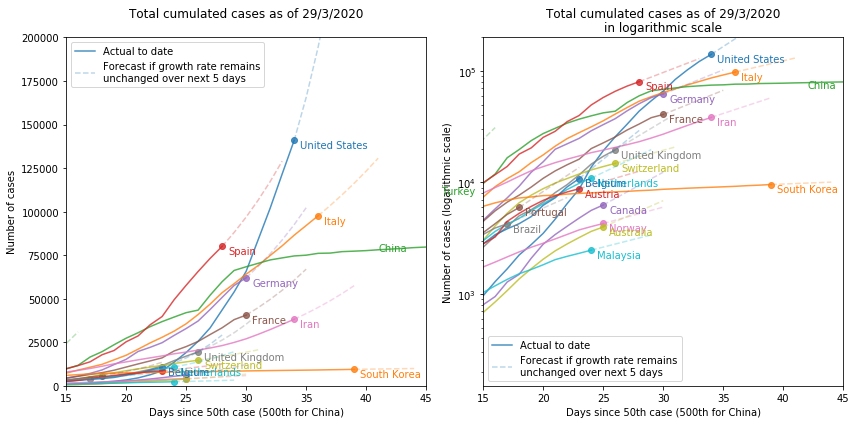

In [38]:
xmax = 45
future_days = 5
ylabels = ['Number of cases', 'Number of cases (logarithmic scale)']
latestdate = f'{date.day}/{date.month}/2020'
titles = [f'Total cumulated cases as of {latestdate}\n',
          f'Total cumulated cases as of {latestdate}\nin logarithmic scale']
fig, ax = plt.subplots(figsize=(12,6), nrows=1, ncols=2) 
for s in range(2): # one for log scale, one for regular scale
    for i, country in enumerate(countries):
        color = f'C{i}' if i < 10 else f'C{str(i)[-1]}'   
        # Data for actual
        data = df2.loc[(df2.country==country), 'confirmed'].reset_index(drop=True)
        ax[s].plot(data, alpha=0.8, color=color, label='Actual to date')
        ax[s].scatter(data.index.max(), data.iloc[-1], alpha=0.8, color=color)
        if s==0:
            if i<12 : ax[s].text(xmax-4 if country=='China' else data.index.max()+0.5, data.max(), country,
                                 va='top', ha='left', fontsize=10, color=color)
        else:
            ax[s].text(xmax-3 if country=='China' else data.index.max()+0.5, data.max(), country,
                       va='top', ha='left', fontsize=10, color=color)
        # Data for forecast
        latest_growth = df2.loc[(df2.country==country), 'growth'].rolling(window=2).mean().iloc[-1]
        latest_total = df2.loc[(df2.country==country), 'confirmed'].iloc[-1]
        extrapolate = [data.iloc[-1]]
        new_data = latest_total
        for day in range(future_days):
            new_data = new_data * latest_growth
            extrapolate.append(new_data)
        xdays = range(data.index.max(), data.index.max()+future_days+1)
        ax[s].plot(xdays, extrapolate, alpha=0.3, ls='dashed', color=color, label=f'Forecast if growth rate remains\nunchanged over next {future_days} days')
        if i==0: ax[s].legend()
    if s==1: plt.yscale('log')
    ax[s].set_title(titles[s])
    ax[s].set_xlim(xmax-30, xmax)
    ax[s].set_ylim(1.5e2, 2e5)
    ax[s].set_ylabel(ylabels[s])
    ax[s].set_xlabel('Days since 50th case (500th for China)')
plt.tight_layout()
plt.savefig(f'img/total_cases', pad_inches=0)
plt.savefig(f'img_archive/total_cases_{str(date)[:10]}', pad_inches=0)
plt.show()

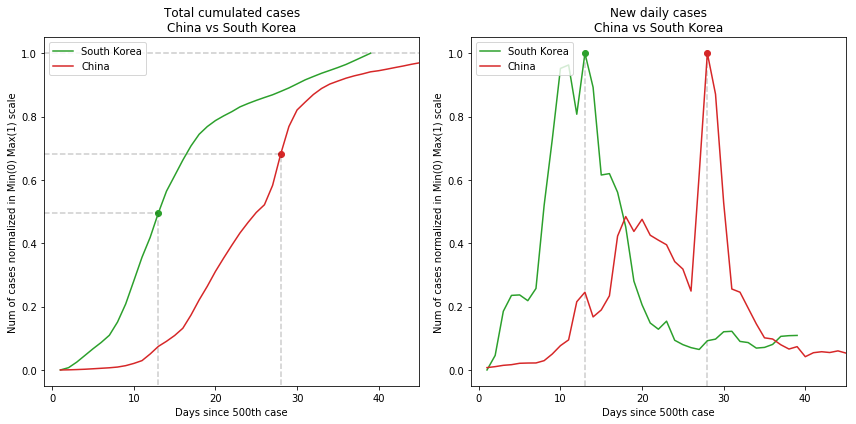

In [17]:
color = ['C2','C3']
cols = ['confirmed','new_confirmed']
titles = ['Total cumulated cases\nChina vs South Korea', 'New daily cases\nChina vs South Korea']
fig, axes = plt.subplots(figsize=(12,6), nrows=1, ncols=2)
for i, ax in zip(range(len(cols)), axes.flat):
    for c, country in enumerate(['South Korea','China']):
        data0 = df2.loc[df2.confirmed > 500]
        data1 = df2.loc[df2.country==country][cols[i]].rolling(2).sum().reset_index(drop=True)
        if i==1:
            peakday = data1[data1==data1.max()].index[0]
        else:
            data2 = df2.loc[df2.country==country][cols[i+1]].rolling(2).sum().reset_index(drop=True)
            peakday = data2[data2==data2.max()].index[0]
        scaler = MinMaxScaler()
        data = scaler.fit_transform(np.array(data1).reshape(-1, 1))
        ax.plot(data, label=country, color=color[c])
        if i==1:
            ax.vlines(peakday, -0.05, 1, linestyle='dashed', alpha=0.2)
            ax.scatter(peakday, 1, marker='o', color=color[c])
        else:
            ax.vlines(peakday, -1, data[peakday], linestyle='dashed', alpha=0.2)
            ax.hlines(data[peakday], -1, peakday, linestyle='dashed', alpha=0.2)
            ax.hlines(1, -1, xmax, linestyle='dashed', alpha=0.1)
            ax.scatter(peakday, data[peakday], marker='o', color=color[c])
        ax.set_title(titles[i])
        ax.set_xlim(-1, xmax)
        ax.set_ylim(-0.05, 1.05)
        ax.set_ylabel('Num of cases normalized in Min(0) Max(1) scale')
        ax.set_xlabel('Days since 500th case')
        ax.legend(loc='upper left')
        plt.tight_layout()
plt.savefig('img/china_korea', pad_inches=0)
plt.show()

### 3. Forecasting

In [18]:
# country='United Kingdom'
# rolling=1
# days=50
# fit_start='20200311'
# fit_end='20200320'
# showzero=True
# showpeak=True
# A=None
# K=None
# C=None
# Q=None
# B=None
# v=None

# Generalised logistic function (Richard's curve)
def richards(x, A, K, C, Q, B, v):
    y = A + (K-A) / ((C + (Q * np.exp(-1 * B * x))) ** (1/v))
    return y

# Fit to Richard's curve model
def predict_plot(country, rolling=1, fit_start=None, fit_end=None, days=110,
                 showzero=True, showpeak=True, A=None, K=None, C=None, Q=None, B=None, v=None, df2=df2):

    # All dates in raw Actuals
    dates = df2.loc[df2.country==country].reset_index(drop=True).date
    # All raw Actuals
    actual0    = df2.loc[df2.country==country, 'confirmed'].reset_index(drop=True)
    actual0new = df2.loc[df2.country==country, 'new_confirmed'].reset_index(drop=True)

    # Limit Actual data period for model fit
    oneday = pd.Timedelta(1, unit='days')
    fit_start   = pd.to_datetime(fit_start, format='%Y%m%d')
    fit_end     = pd.to_datetime(fit_end, format='%Y%m%d')
    index_start = list(dates[dates==fit_start].index)[0] if fit_start != None else None
    index_end   = list(dates[dates==fit_end+oneday].index)[0] if fit_end != None else None
    actual1 = actual0.iloc[index_start:index_end]

    # Data for model fit input after rolling average
    dropna = range(actual1.index.min(),actual1.index.min()+(rolling-1))
    actual2 = actual1.rolling(window=rolling).mean().drop(dropna) if rolling > 1 else actual1
    xdata = np.array(range(rolling,len(actual2)+rolling)) # TO BE CHECKED
    ydata = np.array(actual2.values)

    # Auto fit model
    popt, pcov = curve_fit(richards, xdata, ydata, maxfev=3000)
    # Hyperparams of auto fit
    A0, K0, C0, Q0, B0, v0 = popt

    # Overwrite auto fit hyperparams if manual value exists
    A = A0 if A==None else A
    K = K0 if K==None else K
    C = C0 if C==None else C
    Q = Q0 if Q==None else Q
    B = B0 if B==None else B
    v = v0 if v==None else v

    #Calculate prediction over required num of days
    xdata2 = np.array(range(days))
    predcalc = richards(xdata2, A, K, C, Q, B, v)

    # Assign prediction into df and shift index to match the correct nth day
    index = range(actual2.index.min(), days+actual2.index.min()) # TO BE FIXED !!!
    predict = pd.DataFrame(predcalc, columns=['predict'], index=index)
    predict = predict.iloc[:,0]

    # Forecast dates that overlap with Actuals
    predict_dates1 = list(filter(lambda row: row <= dates.index.max(), list(predict.index)))
    dates_part_1 = []
    for dy in predict_dates1:
        dates_part_1.append(dates.loc[dy])
    predict_dates2 = list(filter(lambda row: row > dates.index.max(), list(predict.index)))

    # Forecast dates beyond Actuals period
    dates_part_2 = []
    for ix in range(len(predict_dates2)):
        dates_part_2.append(dates.max() + oneday * (ix+1))

    # Forecast dates (all)    
    predict_dates = dates_part_1 + dates_part_2

    # Find dates for plot labels
    # Latest available date in raw Actual
    latestdate = dates.iloc[-1]
    # Calculate difference between predicted days to find plateau
    predict = predict if predict.isna().sum() > 0 else predict.astype('int')
    newcase0 = predict.diff().drop(predict.index.min())
    newcase1 = newcase0.loc[actual2.index.max():] # exclude if zero happens during Actual period
    # If prediction doesn't coverge to plateau, don't show
    if np.isnan(newcase1[newcase1==0].index.min()):
        showzero = False
    # If prediction converges to plateau:
    else:
        # Day when difference between days equal to zero
        zerocase = newcase1[newcase1==0].index.min()
        to_go_weeks = int(round((zerocase - actual2.index.max())/7))
        oneday = pd.Timedelta(1, unit='days')
        # Day when daily peak is reached
        zerodate = latestdate + oneday * to_go_weeks * 7
    # If turning point has happened during actuals, don't show
    #if actual0new.index.max() >= newcase0[newcase0==newcase0.max()].index[0]:
    if newcase0[newcase0==newcase0.max()].index[0] - actual0new.index.max() < 5:
        showpeak = False
    else:
        turning_point = newcase0[newcase0==newcase0.max()].index[0]
        to_peak_days  = turning_point - actual0new.index.max()
        to_peak_weeks = int(round(to_peak_days/7))
        turning_date  = predict_dates[turning_point-predict.index.min()]

    fig, ax = plt.subplots(figsize=(12,5), ncols=2, nrows=1)
    mdict = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

    # Plot prediction
    ax[0].plot(predict_dates, predict.values.clip(0),  ls='dashed', c='#ff7f0e', label='Forecast')
    ax[1].plot(predict_dates[1:], newcase0.values.clip(0), ls='dashed', c='#ff7f0e', label='Forecast')

    # Plot actual
    ax[0].plot(dates.values, actual0.values, c='C0', label='Actual to date')
    ax[0].scatter(dates.values[-1], int(actual0.iloc[-1]), c='C0')
    ax[0].text(dates.values[-1], actual0.iloc[-1], f'{latestdate.day} {mdict[latestdate.month]}\n{format(int(actual0.iloc[-1]), ",")} cases', va='top')
    ax[1].plot(dates.values, actual0new.values, c='C0', label='Actual daily')

    # Plot actual moving average
    if rolling > 1:
        ax[0].plot(dates.loc[actual2.index].values, actual2.values, ls=':', label=f'Act {rolling}-day moving avg')

    # Plot prediction end points
    if showzero==True:
        ax[0].scatter(zerodate, predict.max(), c='C1')      
        predictmax = int(math.ceil(predict.max()/100.0))*100 if predict.max() > actual2.iloc[-1] else int(math.ceil(actual0.iloc[-1]/100.0))*100
        ax[0].text(zerodate, predictmax, f"{zerodate.day} {mdict[zerodate.month]}\n{format(predictmax, ',')} cases\nin {to_go_weeks} week{'s' if to_go_weeks>1 else ''}", va='top')
    if showpeak==True:
        ax[1].scatter(turning_date, newcase0.max(), c='C1')
        to_peak = f"{to_peak_weeks} week{'s' if to_peak_weeks>1 else ''}"
        ax[1].text(turning_date, newcase0.max(), f"{turning_date.day} {mdict[turning_date.month]}\nin {to_peak}", va='top')

    # Plot titles and axis
    ax[0].set_title(f'{country.upper()}\nTotal cumulated cases')
    ax[0].set_ylabel('Num of cumulative cases')    
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    ax[0].legend(loc='center right')

    ax[1].set_title(f'{country.upper()}\nNew daily cases')
    ax[1].set_ylabel('Num of new daily cases')
    ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    ax[1].legend(loc='center right')
    
    fig.autofmt_xdate(rotation=90)
    plt.tight_layout()
    plt.savefig(f"img/forecast_{country.replace(' ','_')}", pad_inches=0)
    plt.savefig(f"img_archive/forecast_{country.replace(' ','_')}_{str(latestdate)[:10]}", pad_inches=0)    
    plt.show()

    print(country)
    print(f'Auto fit  : A={int(A0)}, K={int(K0)}, C={round(C0,4)}, Q={round(Q0,4)}, B={round(B0,4)}, v={round(v0,4)}')
    if (A!=A0) | (K!=K0) | (C!=C0) | (Q!=Q0) | (B!=B0) | (v!=v0):
        print(f'Manual fit: A={int(A)}, K={int(K)}, C={round(C,4)}, Q={round(Q,4)}, B={round(B,4)}, v={round(v,4)}')

**Instructions on how to run the model**

In [19]:
# Use predict_plot function to run model by country:
#
# predict_plot('United Kingdom',                         # compulsory
#              rolling=1,                                # optional: number of period of moving avg if > 1
#              fit_start='20200311', fit_end='20200311', # optional: but essential if converge error
#              days=110,                                 # optional: number of days to plot (default 110)
#              A=.., K=.., C=.., Q=.., B=.., v=..        # optional: manual tweak of Richard's curve parameters
#              showzero=True, showpeak=True)             # optional: show or hide date of plateau or peak
#
# 1. Run the function with predict_plot(country)
#
# 2. If error message "Optimal parameters not found" is generated, this means that
#    data points can't be fit into a curve due to failure to converge after 3000 iterations
#
# 3. In case of such error, change fit_start or/and fit_end (dates) and/or rolling period (days)
#    manually until the error disappears and a resonable result is generated.
#
# 4. If the curve overfits and/or it doesn't follow the expected result, tweak A/K/C/Q/B/v
#    parameters manually. Use the auto-generated parameter values shown underneath the plots
#    as a starting point and refer to be guide below on the effect of changing these parameters.

![title](img/richards_curve_params.png)

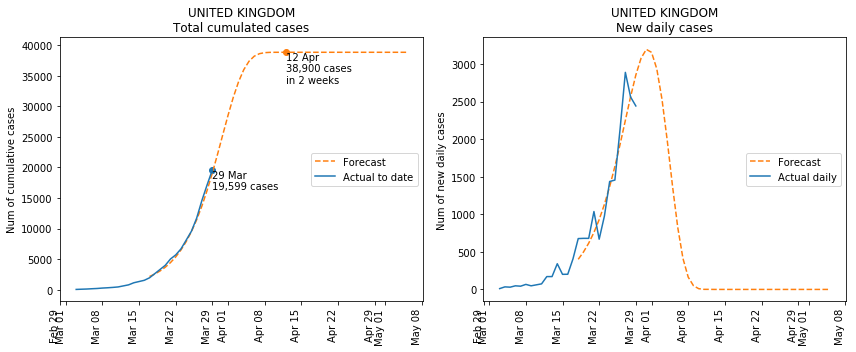

United Kingdom
Auto fit  : A=38835, K=-20027, C=1.0013, Q=0.0001, B=-0.2282, v=0.003
Manual fit: A=38835, K=-20027, C=1.0013, Q=0.0001, B=-0.2282, v=0.003


In [20]:
# predict_plot('United Kingdom', days=50, fit_start='20200311', fit_end='20200321')
predict_plot('United Kingdom', days=50, fit_start='20200317', Q=0.00013)

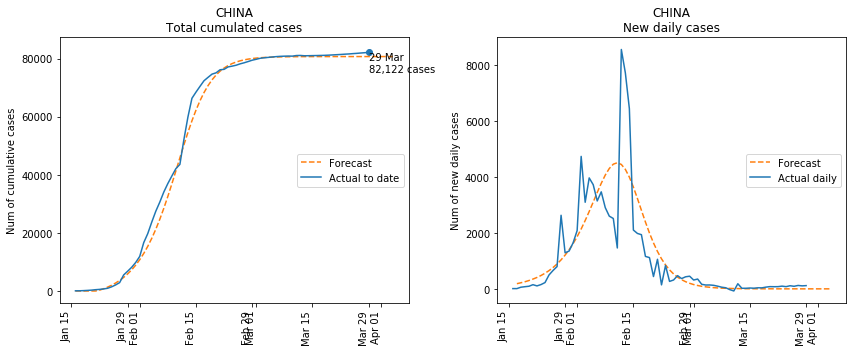

China
Auto fit  : A=-2510, K=5352, C=0.0215, Q=25.3518, B=0.2586, v=1.6283


In [21]:
predict_plot('China', days=80, showzero=False, fit_end='20200323')

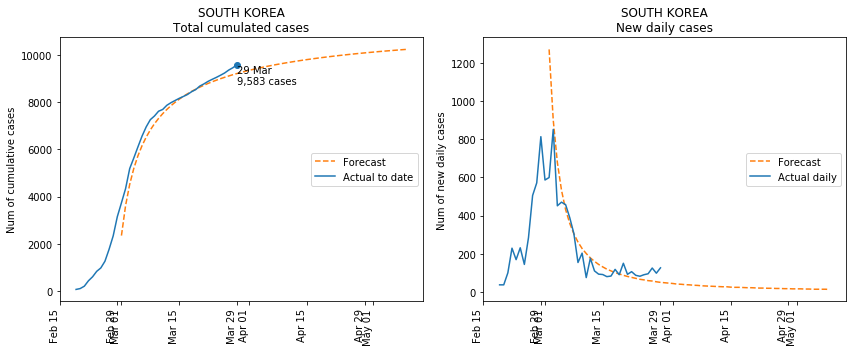

South Korea
Auto fit  : A=11136, K=8959, C=-2.0483, Q=2.1657, B=-0.0146, v=1.5349


In [22]:
#predict_plot('South Korea', rolling=0, days=50, showzero=False, fit_end='20200323')
predict_plot('South Korea', days=70, showzero=False, fit_start='20200301', fit_end='20200326')

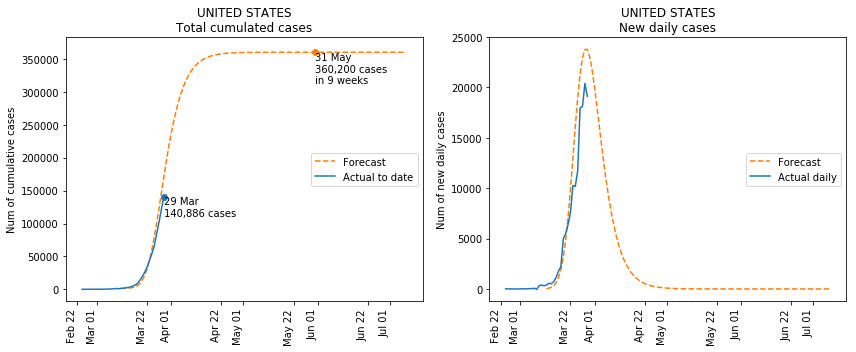

United States
Auto fit  : A=1422, K=2316, C=0.3143, Q=1.3323, B=0.1816, v=0.2133
Manual fit: A=1422, K=3000, C=0.3143, Q=2, B=0.2, v=0.2133


In [23]:
#predict_plot('United States', days=100, fit_start='20200316', fit_end='20200321', showpeak=False, B=-1.5)
#predict_plot('United States', fit_start='20200311', fit_end='20200325', days=100, B=0.3, Q=4)
#predict_plot('United States', days=200, fit_start='20200311', fit_end='20200325', B=0.15, K=4000)
predict_plot('United States', fit_start='20200311', fit_end='20200325', days=120, B=0.2, K=3000, Q=2)

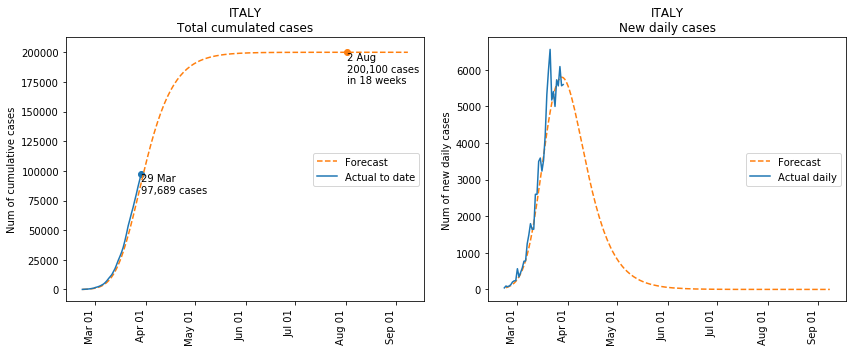

Italy
Auto fit  : A=-94, K=2952, C=0.3288, Q=1.9149, B=0.0891, v=0.2658


In [24]:
predict_plot('Italy', days=200, showpeak=False, fit_end='20200319')

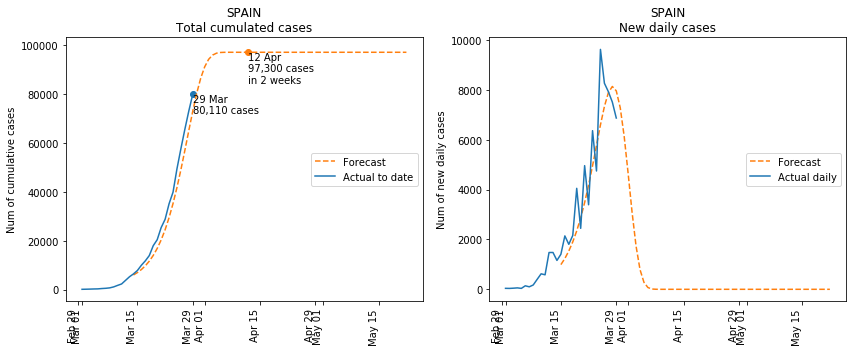

Spain
Auto fit  : A=97223, K=-89959, C=1.0007, Q=0.0, B=-0.2334, v=0.001


In [25]:
#predict_plot('Spain', days=70, fit_start='20200313', fit_end='20200323')
predict_plot('Spain', days=70, fit_start='20200314')

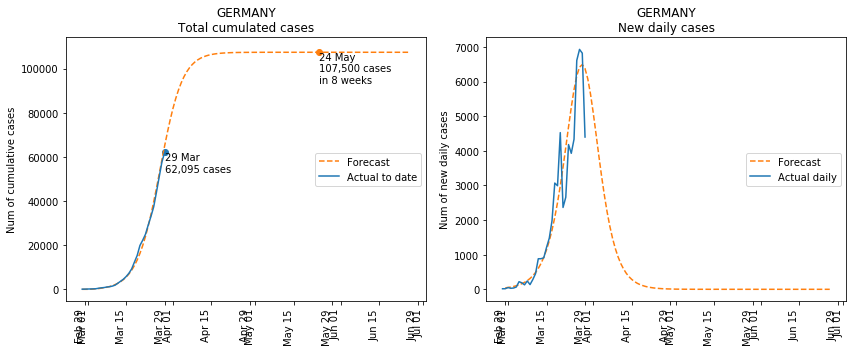

Germany
Auto fit  : A=-8, K=167, C=0.0023, Q=3.1241, B=0.3035, v=1.1152
Manual fit: A=-300, K=167, C=0.0023, Q=3.1241, B=0.25, v=1.1152


In [26]:
predict_plot('Germany', rolling=1, days=120, fit_end='20200317', showpeak=False, A=-300, B=0.25)

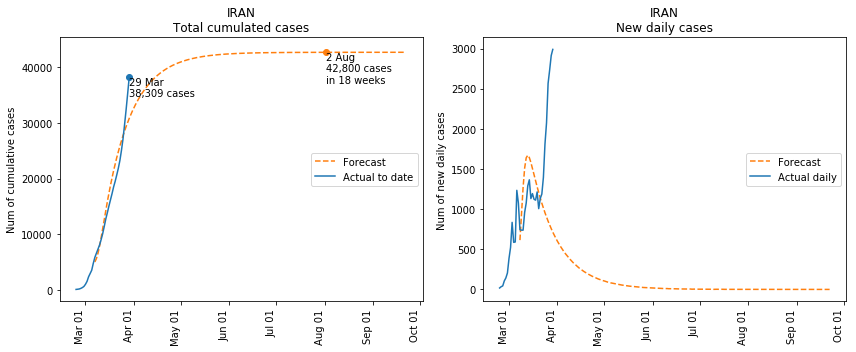

Iran
Auto fit  : A=42715, K=3417, C=1.2854, Q=0.3518, B=-0.4193, v=9.1439
Manual fit: A=42715, K=3417, C=1.2854, Q=0.3518, B=-0.7, v=12


In [27]:
predict_plot('Iran', days=200, fit_start='20200307', fit_end='20200321', B=-0.7, v=12)
#predict_plot('Iran', days=200, fit_start='20200309', fit_end='20200321')

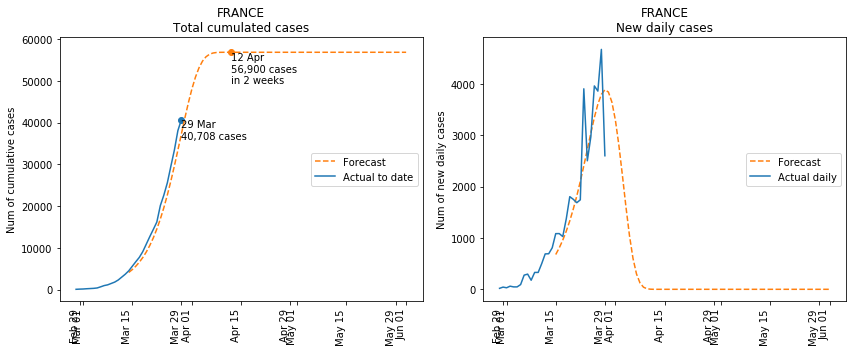

France
Auto fit  : A=56859, K=-45237, C=1.0009, Q=0.0001, B=-0.1888, v=0.0015


In [28]:
#predict_plot('France', days=80, fit_start='20200309', fit_end='20200320')
predict_plot('France', days=80, fit_start='20200314')

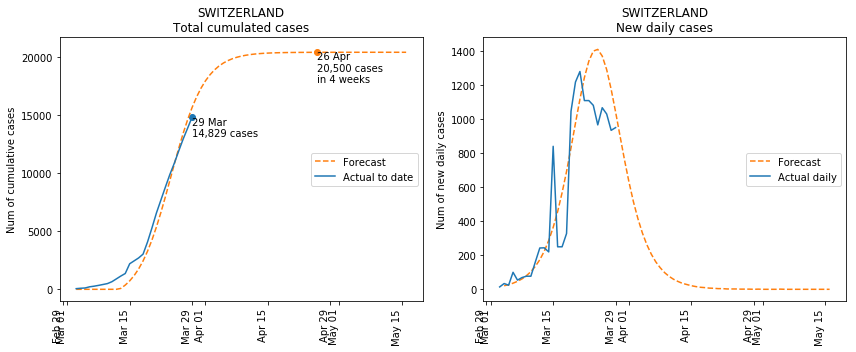

Switzerland
Auto fit  : A=35, K=991, C=0.0609, Q=15.1043, B=0.2621, v=0.9559
Manual fit: A=-900, K=240, C=0.0609, Q=15.1043, B=0.2621, v=0.9559


In [29]:
predict_plot('Switzerland', days=75, K=240, A=-900)

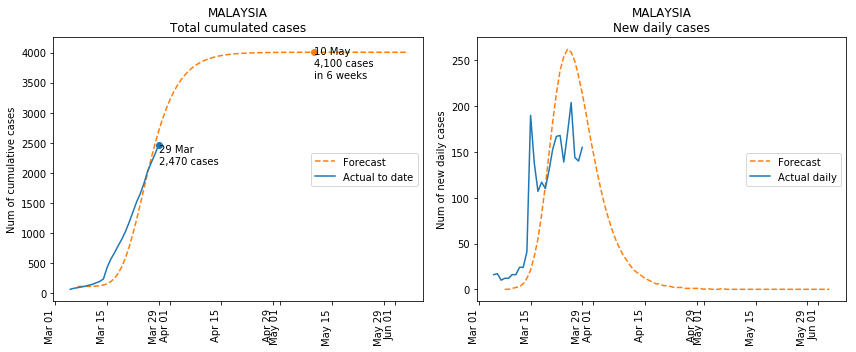

Malaysia
Auto fit  : A=113, K=199, C=0.6101, Q=4.4736, B=0.3538, v=0.1894
Manual fit: A=113, K=400, C=0.6101, Q=4, B=0.2, v=0.1894


In [30]:
#predict_plot('Malaysia', days=60, fit_start='20200307', fit_end='20200320', K=300, B=0.3, Q=5)
predict_plot('Malaysia', days=90, fit_start='20200307', fit_end='20200320', K=400, B=0.2, Q=4)
#predict_plot('Malaysia', days=100, fit_start='20200313', fit_end='20200325')

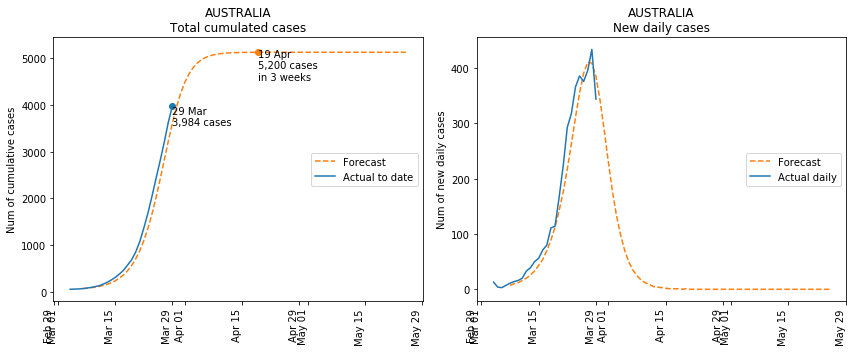

Australia
Auto fit  : A=42, K=140, C=0.0029, Q=7.142, B=0.3725, v=1.4798


In [31]:
#predict_plot('Australia', days=60, fit_end='20200317', B=0.25, showpeak=False)
#predict_plot('Australia', days=80, fit_start='20200307', fit_end='20200317', showpeak=False, B=0.28, K=300, Q=12)
predict_plot('Australia', days=80, fit_start='20200307', fit_end='20200328')